# Discrete Wavelet Transform

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
N = 1024

k = np.linspace(0, N-1, N)

print(f'Smallest Normalized Frequency = {1/N}')

imp = (0*k)
imp[0] = 1

Smallest Normalized Frequency = 0.0009765625


## Function Definitions

Return Fourier Transform between -0.5 and 0.5

In [27]:
def fft(x_k):
    return np.fft.fftshift(np.fft.fftfreq(len(x_k))), np.fft.fftshift(np.fft.fft(x_k))

Inverse of above function

In [28]:
def ifft(x_f):
    return np.real(np.fft.ifft(np.fft.ifftshift(x_f)))

### Low Pass Filter

$y[k] = \frac{x[k]+x[k+1]}{2}$

In [29]:
def lpf(x_k):
    x2 = np.roll(x_k,-1)
    return (x_k+x2)/2

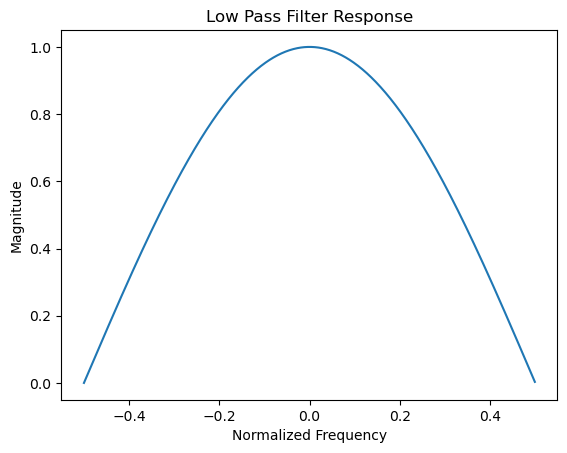

In [30]:
f, lpf_f = fft(lpf(imp))

plt.title("Low Pass Filter Response")
plt.plot(f, np.abs(lpf_f))
plt.xlabel("Normalized Frequency")
plt.ylabel("Magnitude")
plt.show()

### High Pass Filter

$ y[k]  = \frac{x[k]-x[k+1]}{2}$

In [31]:
def hpf(x_k):
    x2 = np.roll(x_k,-1)
    return (x_k-x2)/2

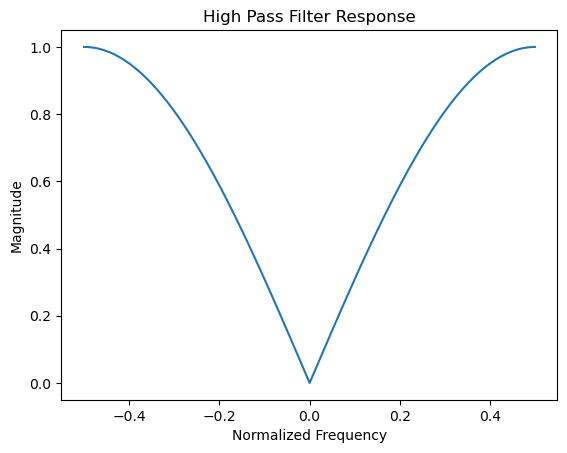

In [32]:
f, hpf_f = fft(hpf(imp))

plt.title("High Pass Filter Response")
plt.plot(f, np.abs(hpf_f))
plt.xlabel("Normalized Frequency")
plt.ylabel("Magnitude")
plt.show()

## Multi-Tone Signal

In [33]:
x_k = np.random.random(N)
x_k = x_k-np.average(x_k)

print(f'Length of signal = {len(x_k)} samples')

Length of signal = 1024 samples


In [34]:
x_k = np.cos(np.pi/16*k) + 0.35*np.cos(np.pi/13*k) #+ 0.55*np.cos(2*np.pi/3*k) + np.cos(5*np.pi/6*k)

In [35]:
# x_k = 0*k
# x_k[0:len(k)//2] = 2
# x_k[len(k)//2:] = 1

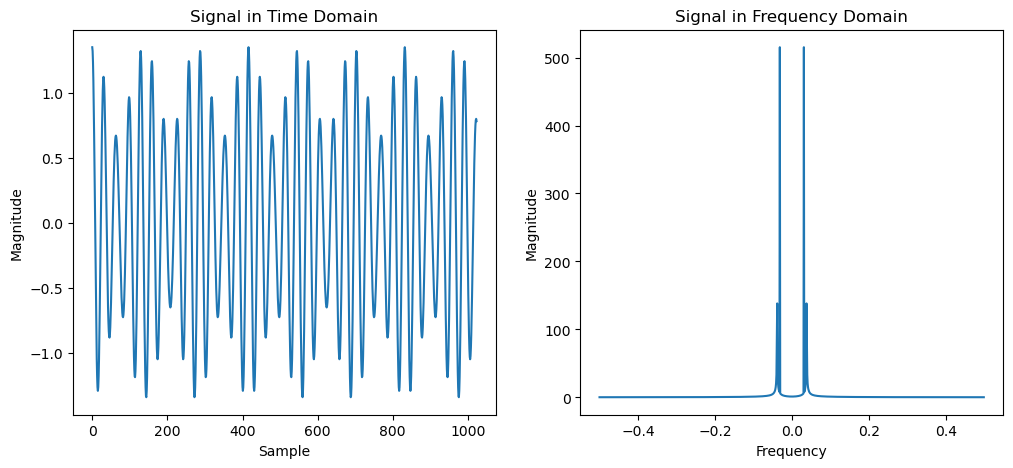

In [36]:
f, x_f = fft(x_k)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(k, x_k)
plt.xlabel("Sample")
plt.ylabel("Magnitude")
plt.title("Signal in Time Domain")

plt.subplot(1,2,2)
plt.plot(f, np.abs(x_f))
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Signal in Frequency Domain")

plt.show()

[]

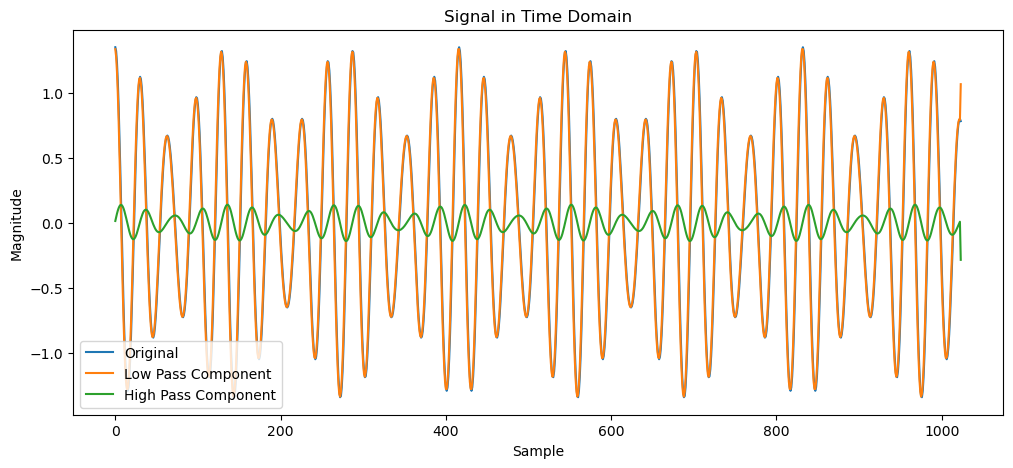

In [37]:
plt.figure(figsize=(12,5))

plt.plot(k, x_k)
plt.plot(k, lpf(x_k))
plt.plot(k, hpf(x_k))

plt.xlabel("Sample")
plt.ylabel("Magnitude")
plt.title("Signal in Time Domain")
plt.legend(["Original","Low Pass Component","High Pass Component"])

plt.plot()

## DWT

In [38]:
def dwt(x_k, levels=-1):
    n = len(x_k)
    levels = int(np.log2(n)) if levels<0 else levels
    coeffs = np.zeros(n)
    x_lp = x_k
    i = n
    for _ in range(levels):
        x_hp = hpf(x_lp)[::2]
        x_lp = lpf(x_lp)[::2]
        coeffs[i-n//2:i] = x_hp
        i -= n//2
        n = n//2
    coeffs[:i] = x_lp
    return coeffs

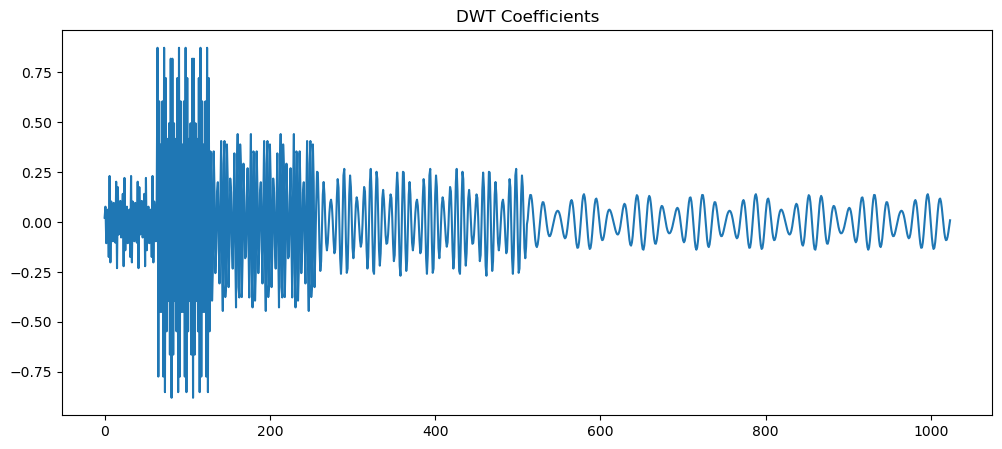

In [39]:
plt.figure(figsize=(12,5))

plt.title("DWT Coefficients")
plt.plot(dwt(x_k, levels=4))
plt.show()

## Inverse DWT

In [40]:
def idwt(coeffs, levels, levels_to_use=-1):
    N = len(coeffs)
    n = 2**levels
    x_r = np.zeros(N)

    levels_to_use = levels if levels_to_use<0 else levels_to_use

    scal = np.zeros(N)
    scal[0:n] = 1

    wav = np.zeros(N)
    wav[0:n//2] = 1
    wav[n//2:n] = -1

    for i in range(N//n):
        x_r += coeffs[i]*np.roll(scal, n*i)

    for _ in range(levels_to_use):
        for j in range(N//n):
            x_r += coeffs[N//n+j]*np.roll(wav, n*j)
        n = n//2
        wav = np.zeros(N)
        wav[0:n//2] = 1
        wav[n//2:n] = -1
    
    print(f'Using {N//n} out of {N} samples')
    print(f'Compression ratio = {100/n} %')
    return x_r

Using 256 out of 1024 samples
Compression ratio = 25.0 %


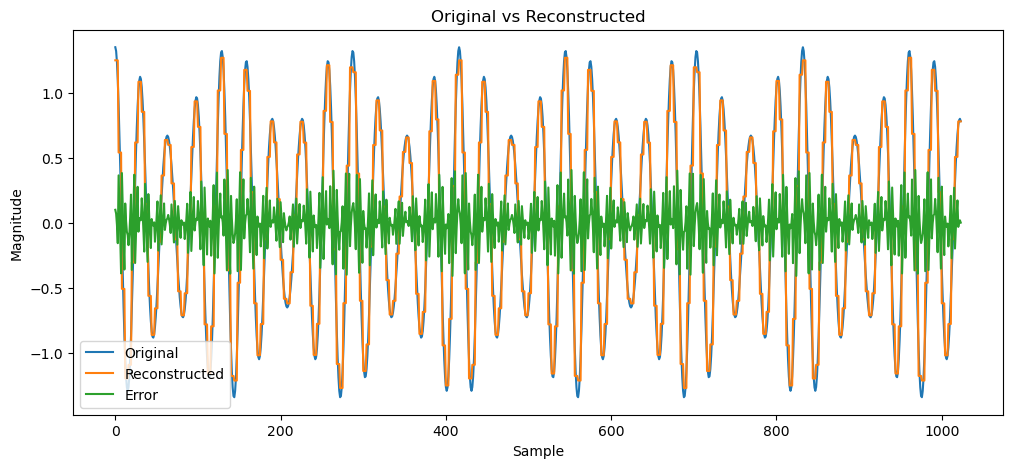

In [41]:
levels = 10
coeffs = dwt(x_k, levels=levels)

x_r = idwt(coeffs, levels, levels_to_use=8)

plt.figure(figsize=(12,5))
plt.plot(x_k)
plt.plot(x_r)
plt.plot(x_k-x_r)
plt.xlabel("Sample")
plt.ylabel("Magnitude")
plt.title("Original vs Reconstructed")
plt.legend(["Original","Reconstructed","Error"])
plt.show()

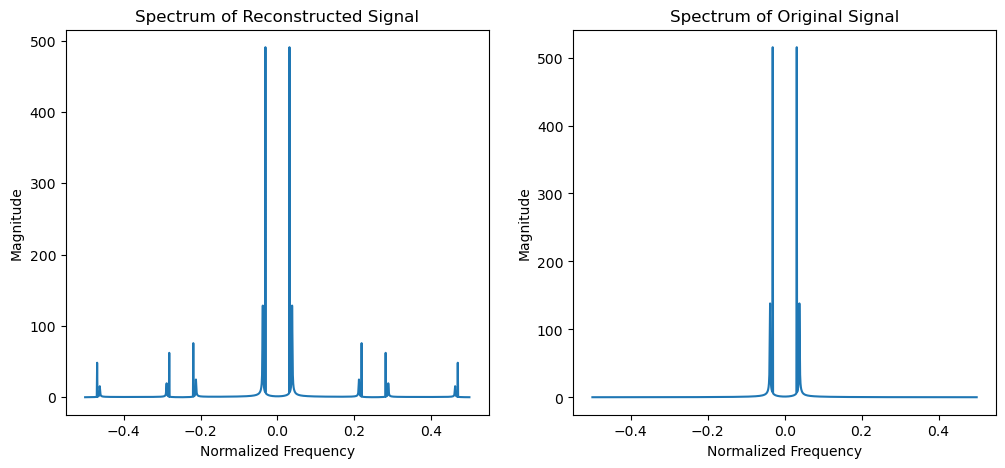

In [42]:
f, x_r_f = fft(x_r)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(f, np.abs(x_r_f))
plt.title("Spectrum of Reconstructed Signal")
plt.xlabel("Normalized Frequency")
plt.ylabel("Magnitude")

plt.subplot(1,2,2)
plt.plot(f, np.abs(fft(x_k)[1]))
plt.title("Spectrum of Original Signal")
plt.xlabel("Normalized Frequency")
plt.ylabel("Magnitude")

plt.show()

## Using PyWavelets Package

In [43]:
import pywt

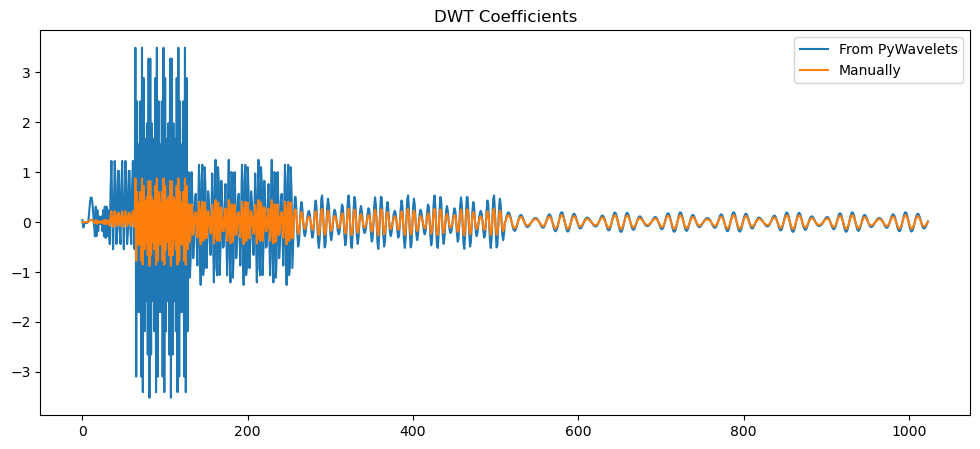

In [44]:
coeff_array = pywt.wavedec(x_k, wavelet='db1', level=10)

coeffs2 = np.zeros(0)
for arr in coeff_array:
    coeffs2 = np.append(coeffs2, arr)

plt.figure(figsize=(12,5))

plt.plot(coeffs2)
plt.plot(coeffs)
plt.title("DWT Coefficients")
plt.legend(["From PyWavelets", "Manually"])


plt.show()

### PyWavelets Uses a scaled DWT Transformation

Scale each level by $\sqrt{2}$ to keep energy constant

In [45]:
def dwt_scaled(x_k, levels=-1):
    n = len(x_k)
    levels = int(np.log2(n)) if levels<0 else levels
    coeffs = np.zeros(n)
    x_lp = x_k
    i = n
    for level in range(levels):
        x_hp = hpf(x_lp)[::2] * np.sqrt(2)
        x_lp = lpf(x_lp)[::2] * np.sqrt(2)
        coeffs[i-n//2:i] = x_hp 
        i -= n//2
        n = n//2
    coeffs[:i] = x_lp
    return coeffs

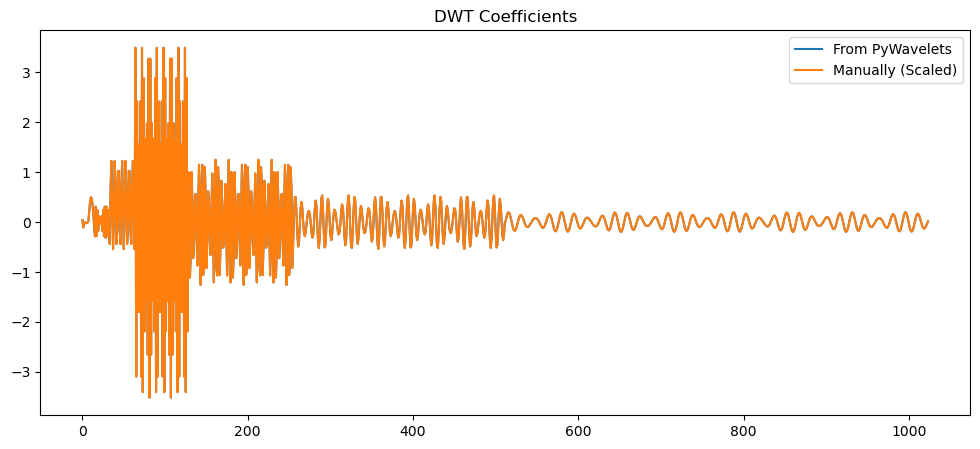

In [46]:
coeffs3 = dwt_scaled(x_k, levels=10)

plt.figure(figsize=(12,5))
plt.plot(coeffs2)
plt.plot(coeffs3)
plt.title("DWT Coefficients")
plt.legend(["From PyWavelets", "Manually (Scaled)"])

plt.show()